# Goal 

Given information about employees at a company, use machine learning models to discover potential discriminations by looking at the data and see if there are segments of employees that are treated worse.

# Data


There are two tables
- company: information about each employee direct boss and her dept
- employee: information about each employee  

In the company there are 6 levels. For each employee, the level could be:
- Individual Contributors(IC) - they don’t manage anyone
- Middle Managers(MM) - they are the direct bosses of IC
- Directors(D) - they are the direct bosses of MM
- VP - D direct bosses
- Executives (E) - VP direct bosses
- CEO - The direct boss of E.


# Load the dataset 

In [52]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
company=pandas.read_csv("company.csv")
company.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [54]:
employee=pandas.read_csv("employee.csv")
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [55]:
company.describe(include='all')

,employee_id,boss_id,dept
count,10000.000000,9999.000000,10000
unique,NaN,NaN,5
top,NaN,NaN,sales
freq,NaN,NaN,3599
mean,100001.855800,103299.980498,NaN
std,57500.488641,57508.798817,NaN
min,40.000000,79.000000,NaN
25%,50574.500000,55883.000000,NaN
50%,99244.500000,102712.000000,NaN
75%,149748.500000,152288.000000,NaN


In [56]:
employee.describe(include = 'all')

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
count,10000.000000,10000.000000,10000.000000,10000,10000,10000.000000
unique,NaN,NaN,NaN,4,2,NaN
top,NaN,NaN,NaN,PhD,M,NaN
freq,NaN,NaN,NaN,2822,6439,NaN
mean,100001.855800,0.301400,189111.800000,NaN,NaN,3.875200
std,57500.488641,0.458889,88973.796898,NaN,NaN,3.107409
min,40.000000,0.000000,60000.000000,NaN,NaN,1.000000
25%,50574.500000,0.000000,110000.000000,NaN,NaN,2.000000
50%,99244.500000,0.000000,182000.000000,NaN,NaN,3.000000
75%,149748.500000,1.000000,255000.000000,NaN,NaN,5.000000


In [57]:
# all employees in the company table are in the employee table
sum(company['employee_id'].sort_values().values == employee['employee_id'].sort_values().values)

10000

In [58]:
employee.isna().sum()

employee_id       0
signing_bonus     0
salary            0
degree_level      0
sex               0
yrs_experience    0
dtype: int64

In [59]:
company.isna().sum()

employee_id    0
boss_id        1
dept           0
dtype: int64

# Exploratory Data Analysis

In [60]:
# identify the level for each employee


#Set all the employee levels to IC
company['level'] = "IC"
  
#identify the CEO
company.loc[company.dept == "CEO", "level"] = "CEO"
  
#assign everyone else based on their boss level
company_levels = ["CEO", "E", "VP", "D", "MM"]
  
for i in range(1,len(company_levels)):
#identify IDs of the boss. This is employee ID of the level above
  boss_id = company.loc[company.level == company_levels[i-1], 'employee_id']
  company.loc[company.boss_id.isin(boss_id), "level"] = company_levels[i]
  

#frequency
print(company.level.value_counts())

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64


In [61]:
# count the number of people that each people manage
# set the number of report to 0 for each employee
company['num_reports'] = 0
  
#same as before, but now we start from the bottom
company_levels = ["IC", "MM", "D", "VP", "E"]
  
i=0
while i<len(company_levels):
  # direct reports + the prior count
  level_count=company.loc[company.level == company_levels[i]].groupby('boss_id')['num_reports'].agg(lambda x: x.count() + x.sum())
                                         
  #join to the main table to get the new report count for the bosses from the step above
  company=pandas.merge(left=company, right=level_count, how='left', left_on="employee_id", right_on="boss_id", suffixes=('', '_updated'))
  company['num_reports'] = company.num_reports_updated.combine_first(company.num_reports)
  
  del company['num_reports_updated']
  i+=1

  
company.sort_values(by=['num_reports'], ascending=False).head()

,employee_id,boss_id,dept,level,num_reports
2427,61554,NaN,CEO,CEO,9999.0
1310,11277,61554.0,sales,E,3598.0
2778,51535,61554.0,engineering,E,2695.0
1009,110464,61554.0,marketing,E,2009.0
9640,93708,61554.0,HR,E,1693.0


In [62]:
# merge two dataset
data = company.merge(employee, on = 'employee_id', how = 'inner')

In [63]:
# remove the record for CEO, which is just one row and hard to predict
data = data.loc[data['dept']!= 'CEO']

In [64]:
# remove the columns: ID and boss ID
data = data.drop(["employee_id","boss_id"], axis = 1)

In [65]:
data.columns

Index(['dept', 'level', 'num_reports', 'signing_bonus', 'salary',
       'degree_level', 'sex', 'yrs_experience'],
      dtype='object')

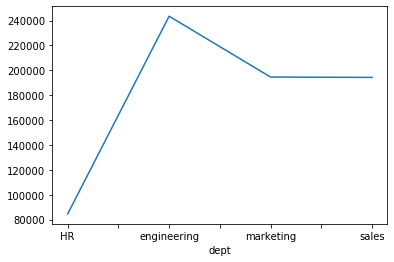

In [66]:
data.groupby(['dept'])['salary'].mean().plot()
plt.show()

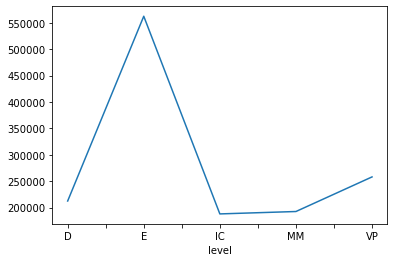

In [67]:
data.groupby(['level'])['salary'].mean().plot()
plt.show()

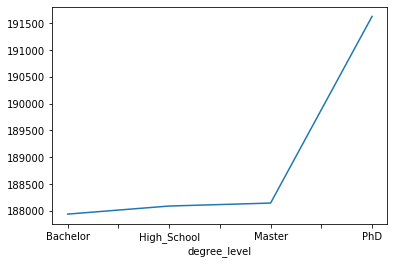

In [68]:
# the average salary for employees with a high school degree seems to be higher than employees with a bachelor degree
data.groupby(['degree_level'])['salary'].mean().plot()
plt.show()

In [69]:
data.degree_level.value_counts()

PhD            2821
Master         2786
Bachelor       2735
High_School    1657
Name: degree_level, dtype: int64

In [73]:
# on average, males are earning more than females
data.groupby(['sex'])['salary'].mean()

sex
F    171314.518394
M    198876.514445
Name: salary, dtype: float64

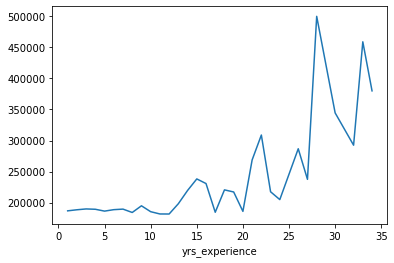

In [74]:
# on average, salary increases with years of experience 
data.groupby(['yrs_experience'])['salary'].mean().plot()
plt.show()

# Salary Prediction

In [75]:
# Since level and degree are conceptually ordered. 
# Replace level and degree with numbers that represent the rank since 
codes = {"High_School":1, "Bachelor":2, "Master":3, "PhD":4}
data['degree_level'] = data['degree_level'].map(codes)
  
codes = {"IC":1, "MM":2, "D":3,"VP":4, "E":5}
data['level'] = data['level'].map(codes)

In [76]:

#Make sex numerical manually
data['is_male'] = np.where(data['sex']=='M', 1,  0)
del data['sex']

In [77]:
#Since variables in this dataset are highly correlated, use a random forest 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [78]:
#create dummy variables. 
#Keep all levels to better extract insights.  all levels here.
data_dummy = pandas.get_dummies(data)

In [79]:
#train/test split
train, test = train_test_split(data_dummy, test_size = 0.34)  
  

rf = RandomForestRegressor(oob_score=True, n_estimators = 100)
rf.fit(train.drop('salary', axis=1), train['salary'])  

RandomForestRegressor(oob_score=True)

In [87]:
train

,level,num_reports,signing_bonus,salary,degree_level,yrs_experience,is_male,dept_HR,dept_engineering,dept_marketing,dept_sales
7039,1,0.0,0,211000.0,2,1,1,0,0,0,1
9520,1,0.0,0,114000.0,1,6,1,0,0,0,1
9998,1,0.0,1,304000.0,1,1,0,0,1,0,0
1392,1,0.0,1,131000.0,2,1,1,0,0,1,0
6620,1,0.0,1,170000.0,2,7,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2279,1,0.0,0,109000.0,3,4,1,0,0,0,1
3365,1,0.0,0,111000.0,1,3,0,0,0,0,1
2407,1,0.0,1,141000.0,3,8,1,0,1,0,0
5173,2,12.0,0,259000.0,3,4,1,0,0,0,1


In [80]:
print("MSE on OOB is", metrics.mean_squared_error(train['salary'], rf.oob_prediction_).round(), "and on test set is", metrics.mean_squared_error(test['salary'], rf.predict(test.drop('salary', axis=1))).round())
  

MSE on OOB is 5677543640.0 and on test set is 5655432450.0


In [81]:
# the accuracy is fare given the variance of salary is big, the insights will be directionally true.
accuracy_25pct =  ((rf.predict(test.drop('salary', axis=1))/test['salary']-1).abs()<.25).mean()
print("We are within 25% of the actual salary in ",  accuracy_25pct.round(2)*100, "% of the cases", sep="")

We are within 25% of the actual salary in 50.0% of the cases


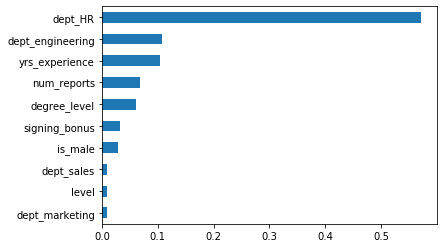

In [82]:
#plot variable importance
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop('salary', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

Based on the plot, the most influential factor is department. Other than department, num_reports, degree_level, and yrs_experience also influence salary. All other variables are fairly irrelevant.

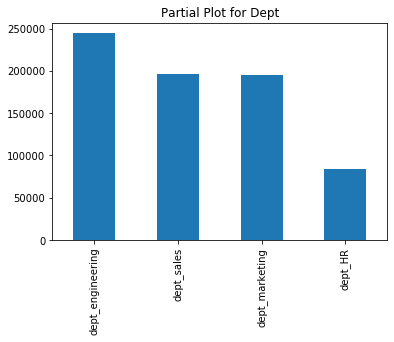

In [83]:
#Check partial dependence plots of the top 2 variables: dept and yrs_experience, as well as sex
from pdpbox import pdp, info_plots
  
#dept
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('salary', axis=1),      
                          model_features=list(train.drop('salary', axis=1)), 
                          feature=['dept_HR', 'dept_engineering', 'dept_marketing', 'dept_sales'], 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for Dept')
plt.show()

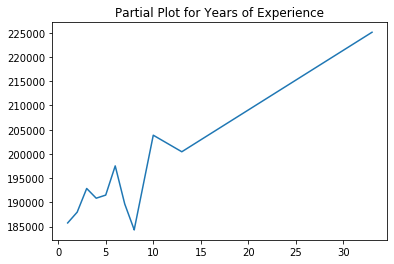

In [84]:
#yrs_experience
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('salary', axis=1),      
                          model_features=list(train.drop('salary', axis=1)), 
                          feature='yrs_experience', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Partial Plot for Years of Experience')
plt.show()

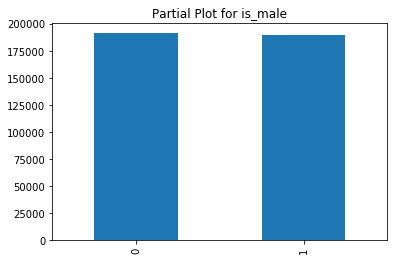

In [85]:
#is_male
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('salary', axis=1),      
                          model_features=list(train.drop('salary', axis=1)), 
                          feature='is_male', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.sort_values(ascending=False).plot(kind='bar',title='Partial Plot for is_male')
plt.show()

In [89]:
#avg salary males vs females by dept
data.groupby(['dept','is_male'])['salary'].agg({'mean', 'count'})

count           mean
dept        is_male                      
HR          0         1058   84399.810964
            1          636   84827.044025
engineering 0          671  246785.394933
            1         2025  242444.444444
marketing   0          651  192502.304147
            1         1359  195639.440765
sales       0         1181  194618.120237
            1         2418  194207.196030

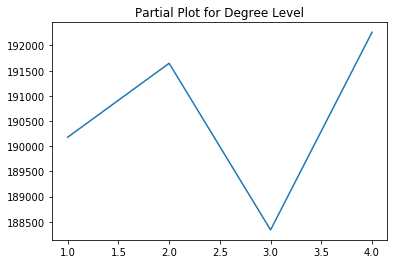

In [88]:
#degree level
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('salary', axis=1),      
                          model_features=list(train.drop('salary', axis=1)), 
                          feature='degree_level', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Partial Plot for Degree Level')
plt.show()

In [90]:
data.groupby(['degree_level'])['salary'].mean()

degree_level
1    188089.318045
2    187938.939671
3    188144.651831
4    191623.537753
Name: salary, dtype: float64

In [100]:
data.groupby(['dept','degree_level'])['salary'].agg({'mean', 'count'})

count           mean
dept        degree_level                      
HR          1               269   83925.650558
            2               483   83519.668737
            3               473   85000.000000
            4               469   85552.238806
engineering 1               465  239935.483871
            2               735  245129.251701
            3               725  244402.758621
            4               771  243334.630350
marketing   1               325  190729.230769
            2               505  193601.980198
            3               582  189180.412371
            4               598  202899.665552
sales       1               598  193195.652174
            2              1012  193413.043478
            3              1006  195498.011928
            4               983  194812.817904

In [98]:
grouped_by_degree = data.groupby(['degree_level','dept'])['salary'].agg({ 'count'})

In [99]:
grouped_by_degree.groupby(['degree_level']).apply(lambda x: 100 * x / float(x.sum()))

count
degree_level dept                  
1            HR           16.234158
             engineering  28.062764
             marketing    19.613760
             sales        36.089318
2            HR           17.659963
             engineering  26.873857
             marketing    18.464351
             sales        37.001828
3            HR           16.977746
             engineering  26.022972
             marketing    20.890165
             sales        36.109117
4            HR           16.625310
             engineering  27.330734
             marketing    21.198157
             sales        34.845799

In [92]:
data.groupby(['dept','degree_level'])['yrs_experience'].agg({'mean', 'count'})

count      mean
dept        degree_level                 
HR          1               269  3.591078
            2               483  3.881988
            3               473  3.813953
            4               469  4.292111
engineering 1               465  3.477419
            2               735  3.653061
            3               725  3.899310
            4               771  4.181582
marketing   1               325  3.430769
            2               505  3.633663
            3               582  3.907216
            4               598  4.414716
sales       1               598  3.550167
            2              1012  3.789526
            3              1006  4.082505
            4               983  3.870804

Department is the main driver of salary. The difference between HR and Engineering is very large. 

Years of experience matters too, but less (note the smaller y range compared to dept). Most importantly, experience seems to matter more past a certain number. That is, salary will start going up after you become fairly senior. Within the first years, it doesn’t have much of an impact taken independently -> to make a lot of money you need to get to a very senior position.

It seems weird that high schoolers are earning more than bachelors and masters. If we look at the average salaries at each department for people with different degrees, we can see that the average salaries are similar for high schoolers, bachelors, and masters. The difference could be due to the fact that the percentage of high schoolers working in the engineering department is high.

Based on the plot, sex doesn’t appear to matter. The difference between males and females is due to the fact that males are more likely to be working in engineering and less in HR. Indeed, if we look at sex and dept together, we now get very similar salaries by sex.



# Next step

To promote gender equality, the company can consider hire more uniformly across departments. I.e. less females in HR and more in engineering. A next step could be to look into candidate pipeline by dept and see if proportion of hires matches proportion of applicants by sex.


The relationship of years of experience vs salary feels a bit worrisome. The company seems to mostly reward experience at the very top, and not much for mid-level professionals. This might lead to poor retention among mid-level people. Having salary grow more linearly vs years of experience would probably help retain those people more.